# Anomaly Detection in System Call Traces

This notebook demonstrates a methodology for detecting anomalies in system call traces using a combination of statistical and machine learning techniques. The primary goal is to distinguish between "clean" and "infected" traces. 

Note: there is an important delta between this pipeline's objective and requirements @ subcom. This pipeline runs a composition of machine learning and statistical techniques on the entire trace file of an application to determine whether it's a deviation from the trained model of "a clean process"; it requires access to the entire trace to find a "segmentation sequence" (longest repeating substring) so that the trace can be segmented and the pipeline can be run on each segment. 

In contrast, subcom requires a production-grade pipeline capable of determining this **online** on a habitual and context-dependent basis, while minimizing false positives.

The pipeline has largely been implemented based on ideas from these publications:
- https://maggi.cc/publication/frossi_hybridsyscalls_2009/frossi_hybridsyscalls_2009.pdf
- https://www.mdpi.com/1424-8220/23/2/652
- https://typeset.io/papers/anomaly-detection-of-system-call-sequence-based-on-dynamic-1oukdqgy

Choice of clustering and temporal models can be changed. The central principle of the paper involves feature engineering system call information to obtain information richer than just the "syscall names/indices", and using the high-dimensional feature set to create informative sub-clusters for each syscall. A typical temporal pipeline can then be employed upon these clusters, treating them as observed states. Further literature search proposes additional enhancements relevant to the domain: **SOMs for pathname similarity, buffer overflow detection by modelling string arg lengths, DoS detection with edge traversal frequencies, segmentation by suffix-tree/autocorrelation based methods.**

*This notebook is experimental and serves as 1) a practical bound on accuracy and 2) a guide for future research efforts.*

In [182]:
import time
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from scipy.signal import savgol_filter
from statsmodels.stats.diagnostic import acorr_ljungbox

In [183]:
from project.utils import process_trace
from project.trace_parser import list_files_in_folder,get_trace_text,parse_trace_text
from project.preprocessing import padding
from project.buffer_overflow import init_strlen_distribution, detect_str_outlier
from project.string_anomaly_som import init_som, detect_string_anomaly_som
from project.clustering import init_cluster_mapping, features_to_states
from project.sequence_model import get_transition_probs
from project.dos_detection import init_edge_frequencies
from project.anomaly_detection import sequence_probability, initialize_pca
from project.segmentation import soe, autocorrelation, segment_sequence, process_segments, merge_segments
from project.suffix_tree import SuffixTree

## Data Retrieval

In this section, we retrieve and parse the system call traces from the specified folders. The traces are divided into "clean" and "infected" categories.

In [3]:
traces_path = "/Users/vismay/PycharmProjects/subcom_pipeline_research/Traces/"

clean_folder = traces_path+"clean/"
trace_files_clean = list_files_in_folder(clean_folder)

infected_folder = traces_path+"infected/"
trace_files_infected = list_files_in_folder(infected_folder)

In [4]:
clean_trace_text_train = get_trace_text(clean_folder, trace_files_clean[:int(.75*len(trace_files_clean))])
clean_trace_text_test = get_trace_text(clean_folder, trace_files_clean[int(.75*len(trace_files_clean)):])
infected_trace_text = get_trace_text(infected_folder, trace_files_infected)

In [5]:
clean_syscall_info_train = parse_trace_text(clean_trace_text_train)
clean_syscall_info_test = parse_trace_text(clean_trace_text_test)
infected_syscall_info = parse_trace_text(infected_trace_text)

In [6]:
infected_syscall_info[0]

['clock_gettime', 'CLOCK_MONOTONIC', '{249453', '99629866}']

## Data Preprocessing

Here, we convert the parsed system call information into feature vectors suitable for the employed techniques.

In [7]:
unique_syscall_types = list(set([info[0] for info in 
                                 clean_syscall_info_train + clean_syscall_info_test + infected_syscall_info]))

syscall_type_mapping = {syscall_type: i for i, syscall_type in enumerate(unique_syscall_types)}

padded_feature_vectors = []
training_str_args = []
max_len = 0

for clean_file in trace_files_clean[:int(.75*len(trace_files_clean))]:
    padded_feature_vectors_i, str_args_i, pad_len = process_trace(clean_folder, clean_file, syscall_type_mapping)
    max_len = max(pad_len, max_len)
    padded_feature_vectors.extend(padded_feature_vectors_i)
    training_str_args.extend(str_args_i)
    
padded_feature_vectors = padding(padded_feature_vectors, max_len)

### Modelling string argument lengths for buffer overflow detection

In [8]:
flattened_str_args = [arg for trace_str_args in training_str_args for arg in trace_str_args]
init_strlen_distribution(flattened_str_args)

Mean string length: 39.76; standard deviation 28.19


In [9]:
### Example use-case; output = `True` if outlier

detect_str_outlier("/Users/vismay/desktop/textbooks/Algorithmic Trading with Interactive Brokers.pdf")

False

## Self-Organizing Map for Pathname & Escape-Sequence Similarity

A Self-Organizing Map (SOM) is used to encode and visualize the similarity of pathnames and escape sequences found in syscall string arguments

=> Initializing Self-Organizing Map
=> Shape of Map Weights: (10, 10, 5)
=> Calculating threshold distance for anomaly detection
=> Threshold distance: 0.4938363022902425


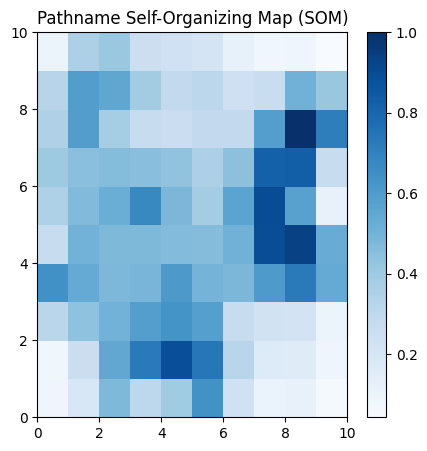

In [10]:
pathnames = list(filter(lambda s: "/" in s, flattened_str_args))
init_som(pathnames)

In [11]:
### Example use-case; output = `True` if anomaly

string_arr = ['/Users/vismay/PycharmProjects/subcom_internship/Traces/subcom_internship/Traces/']
print(detect_string_anomaly_som(string_arr))

string_arr = ['somuser/somedir/someapk/somefile']
print(detect_string_anomaly_som(string_arr))

False
False


## Syscall Probabilistic Subclustering

Syscall feature vectors are clustered using Gaussian Mixture Models (GMM) or K-Means to create a probabilistic model for syscall behavior.

In [12]:
syscall_to_cluster = init_cluster_mapping(padded_feature_vectors)

=> Initializing cluster mapping
=> Done!


In [13]:
training_states = features_to_states(padded_feature_vectors)

## Markov Chain Construction

A Markov Chain is constructed to model the transitions between syscall states (temporal dependencies)

In [14]:
n = 6

In [15]:
transition_probabilities = get_transition_probs(training_states, n)

## Dos Detection with Edge Traversal Frequencies

We analyze the frequencies of edge traversals in the Markov Chain to detect potential DoS attacks. The transition probabilities matrix used for training the markov chain is seperate from the ones used to train Dos Detection. In the markov chain training, we create a transition probability matrix for the entire training corpus (all trace text from designated clean training trace files). For DoS detection, we construct a transition probability matrix for each training clean trace in isolation and compute the frequency of edge traversals to obtain outliers by fitting a beta distribution.

In [17]:
init_edge_frequencies(trace_files_clean, clean_folder, n, syscall_type_mapping)

Edge traversal training: 25% complete
Edge traversal training: 50% complete
Edge traversal training: 75% complete
Edge traversal training: 100% complete


## Segmentation by Autocorrelation

The charts below indicate the degree of autocorrelation/periodicity/repetitiveness of syscall traces which indicate their cyclical nature. This implies that the trace can be segmented into repeating cycles of execution; each cycle can then be evaluated seperately for likelihood. 

This was the key observation that enabled a jump in accuracy by ~10% (from ~80% to ~90%).

In [18]:
training_states_str = [str(ts) for ts in training_states]
encoded_data = []
all_fvecs = []
all_strargs = []

for clean_file in trace_files_clean[:int(.75*len(trace_files_clean))]:   
    feature_vectors, strargs, _ = process_trace(clean_folder, clean_file, syscall_type_mapping)
    all_fvecs.append(feature_vectors)
    all_strargs.append(strargs)
    syscall_idx = [fv[0] for fv in feature_vectors]
    encoded_data.append(syscall_idx)

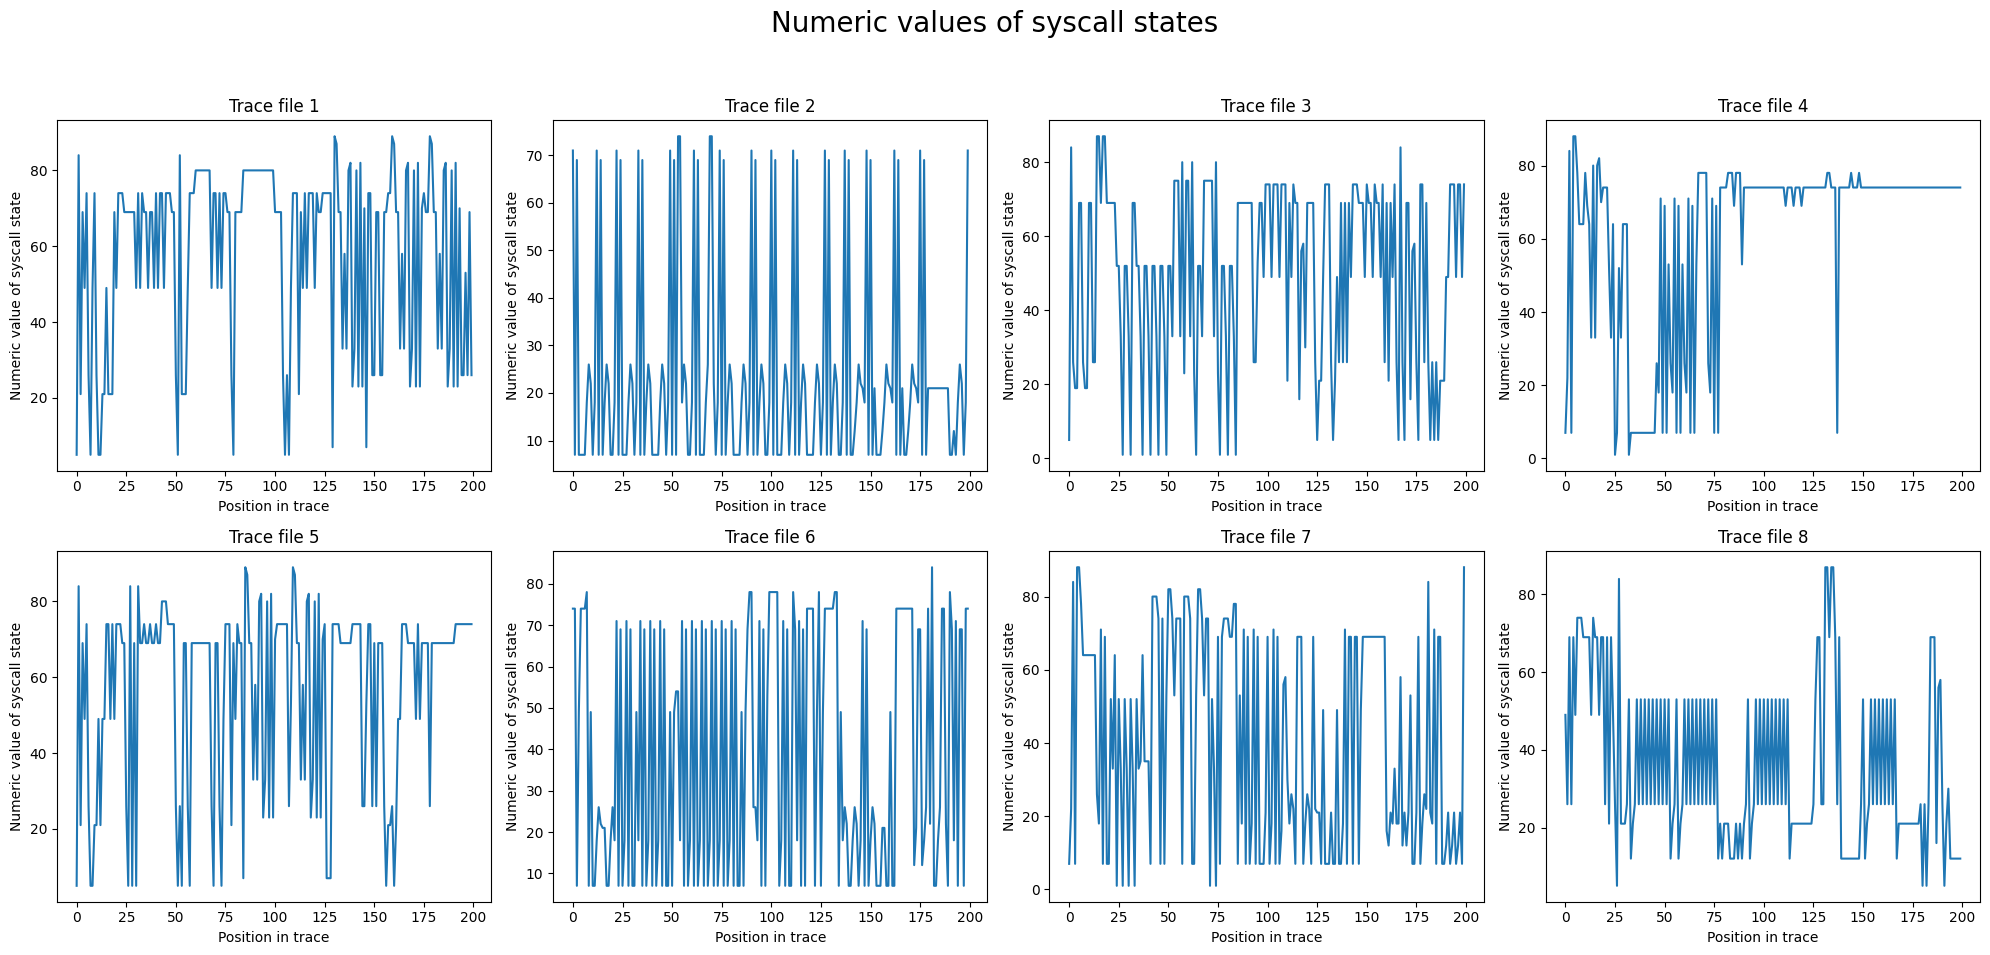

In [19]:
plt.figure(figsize=(20, 10))

for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.plot(encoded_data[i][:200])
        plt.xlabel("Position in trace")
        plt.ylabel("Numeric value of syscall state")
        plt.title(f"Trace file {i+1}")
    
plt.suptitle("Numeric values of syscall states", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

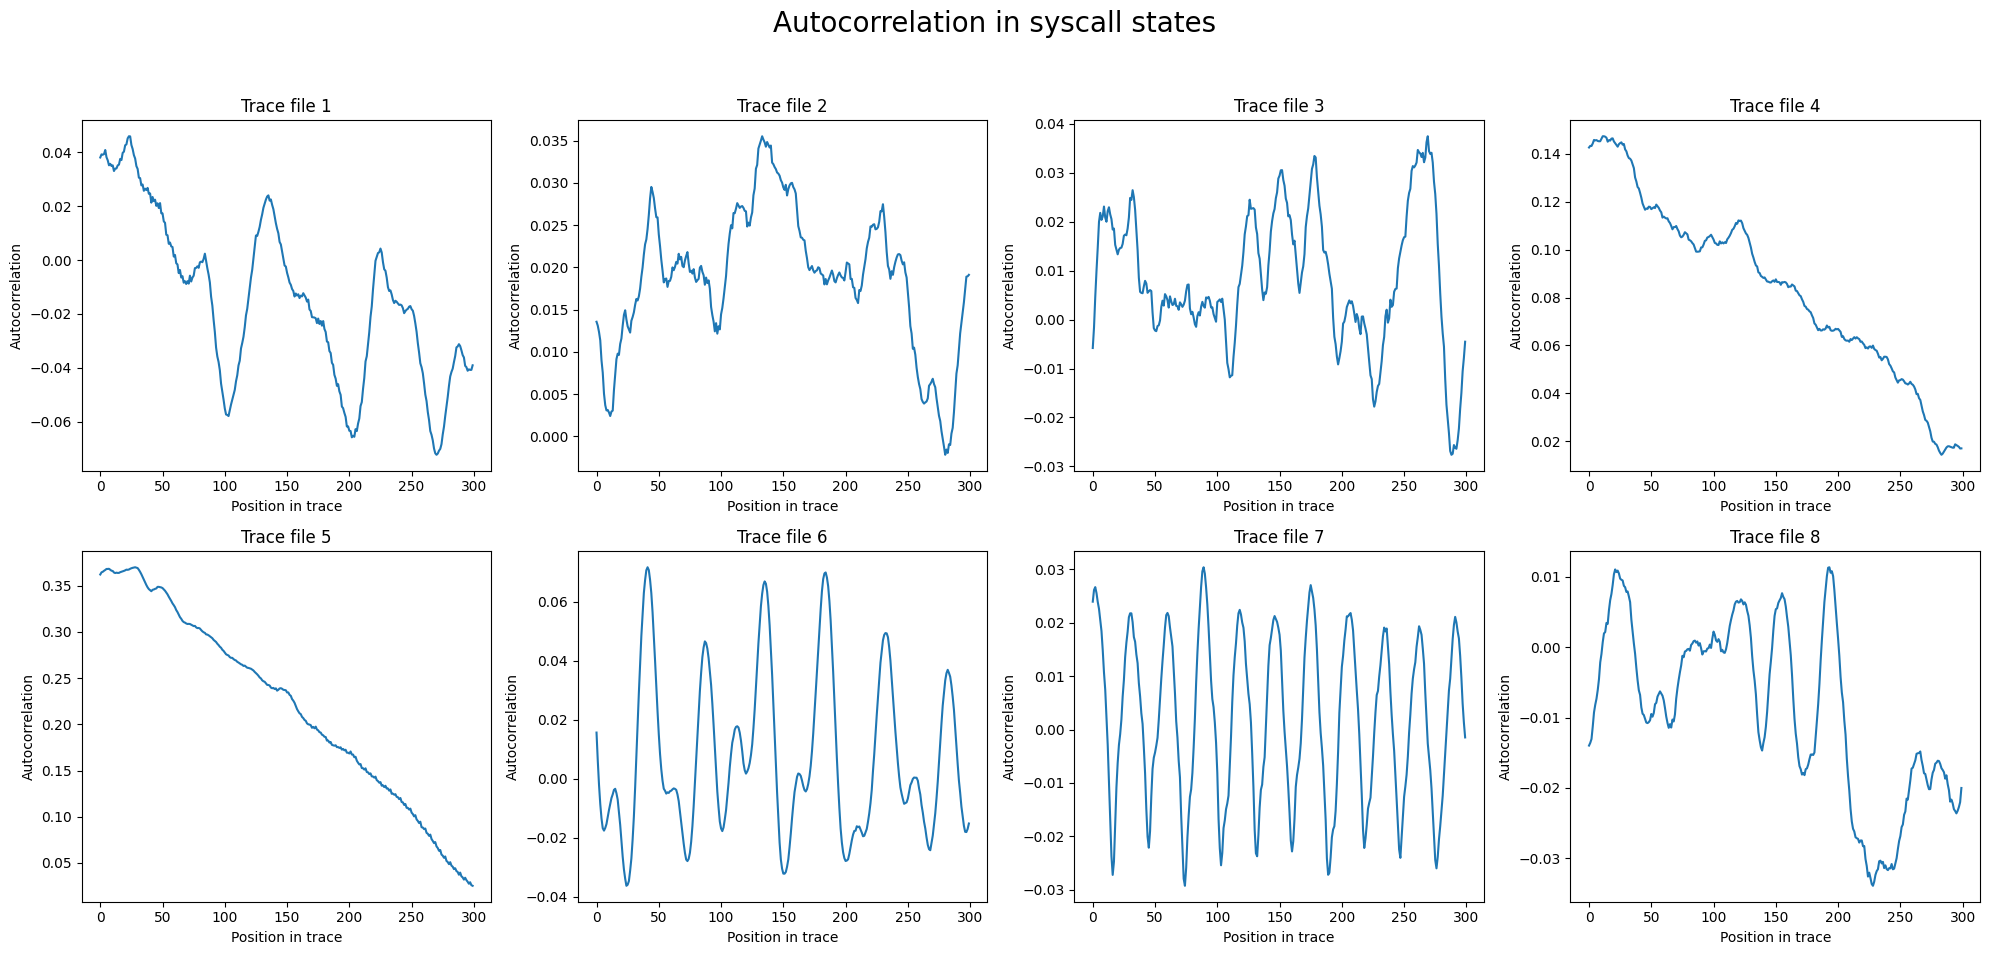

In [20]:
plt.figure(figsize=(20, 10))

for i in range(8):
        plt.subplot(2, 4, i+1)
        acf = autocorrelation(encoded_data[i])
        acf = savgol_filter(acf, window_length=31, polyorder=2)
        plt.plot(acf[200:500])
        plt.xlabel("Position in trace")
        plt.ylabel("Autocorrelation")
        plt.title(f"Trace file {i+1}");
    
plt.suptitle("Autocorrelation in syscall states", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [21]:
def plot_segments(training_segments, idx):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for segments
    color_index = 0
    start_index = 0
    plt.figure()
    plt.xlabel("Position of syscall in sequence")
    plt.ylabel("Syscall numerical value")
    plt.title(f"Syscall sequence segmentation (trace #{idx+1})")

    for segment in training_segments:
        x_values = np.array(list(range(len(segment))))
        y_values = segment
        plt.plot(x_values + start_index, y_values, color=colors[color_index % len(colors)])
        start_index += len(segment)
        color_index += 1

    acf = autocorrelation(encoded_data[idx]) 
    acf = savgol_filter(acf, window_length=6, polyorder=2)
    training_segments_flattened = [segment for sublist in training_segments for segment in sublist]
    acf = acf / max(acf) * max(training_segments_flattened) + np.mean(training_segments_flattened)
    plt.plot(acf, 'black')
    
    plt.show()

This exploration was unable to show a meaningful integration of autocorrelation into the HIDS pipeline; the alternative approach was to build a suffix tree based on a given trace, identify the longest repeating substring in the suffix tree and use this sequence to segment the entire trace (offline approach).

Suggested online approach (for future research efforts): 
1) Use autocorrelation/CUSUM filter + savgol smoothing filter to identify peaks in the trace.
2) Obtain segments based on the observed peaks.
3) Group segments by length / length range and obtain the group with the largest no. of segments.
4) Build a generalized suffix tree atop all the group of segments obtained in (3)
5) Apply Ukkonen's Algorithm to find the Longest Common Subsequence (LCS).
  
This LCS could serve as a "start-of-execution" sequence; it could be used online to identify segmentation points and the pipeline can then be run on the latest observed segment of the incoming syscall trace, hence removing the requirement of having observed the entire trace ahead of time.

In [185]:
class SuffixTreeNode:
    def __init__(self):
        self.edges = {}
        self.suffix_link = None


class SuffixTree:
    def __init__(self, sequence):
        self.sequence = sequence[:]
        if len(sequence) > 0:
            self.sequence.append("$")
        self.n = len(self.sequence)
        self.root = SuffixTreeNode()
        self.remainder = 1
        self.active_point = {
            "active_node": self.root,
            "active_edge": None,
            "active_length": 0
        }
        self.current_end = 0
        self.build_tree()

    def build_tree(self):
        for i in range(self.n):
            self.current_end = i + 1
            self.update_edges(self.root, self.current_end)
            last_new_node = None

            while self.remainder > 0:
                if self.active_point["active_length"] == 0:
                    if self.sequence[i] in self.root.edges:
                        self.active_point["active_edge"] = self.sequence[i]
                        self.active_point["active_length"] += 1
                        break
                    else:
                        self.root.edges[self.sequence[i]] = (i, self.current_end)
                        self.remainder -= 1
                else:
                    if self.active_point["active_edge"] in self.active_point["active_node"].edges:
                        edge_info = self.active_point["active_node"].edges[self.active_point["active_edge"]]
                        edge_start = edge_info[0]
                        edge_length = edge_info[1] - edge_start

                        if self.sequence[edge_start + self.active_point["active_length"]] == self.sequence[i]:
                            self.active_point["active_length"] += 1

                            if self.active_point["active_length"] == edge_length:
                                self.active_point["active_node"] = edge_info[2] if len(edge_info) > 2 else self.root
                                self.active_point["active_edge"] = None
                                self.active_point["active_length"] = 0

                            break
                        else:
                            split_node = SuffixTreeNode()
                            edge_info = self.active_point["active_node"].edges[self.active_point["active_edge"]]
                            edge_start, edge_end = edge_info[0], edge_info[1]
                            split_pos = edge_start + self.active_point["active_length"]

                            split_node.edges[self.sequence[split_pos]] = (split_pos, edge_end)
                            split_node.edges[self.sequence[i]] = (i, self.current_end)

                            self.active_point["active_node"].edges[self.active_point["active_edge"]] = (
                                edge_start, split_pos, split_node)

                            if last_new_node is not None:
                                last_new_node.suffix_link = split_node

                            last_new_node = split_node
                            self.remainder -= 1

                            if self.active_point["active_node"] == self.root and self.active_point["active_length"] > 0:
                                self.active_point["active_length"] -= 1
                                self.active_point["active_edge"] = self.sequence[i - self.remainder + 1]
                            elif self.active_point["active_node"] != self.root:
                                if self.active_point["active_node"].suffix_link is not None:
                                    self.active_point["active_node"] = self.active_point["active_node"].suffix_link
                                else:
                                    self.active_point["active_node"] = self.root
                    else:
                        if self.active_point["active_node"] == self.root:
                            self.active_point["active_length"] -= 1
                            self.active_point["active_edge"] = self.sequence[i - self.remainder + 1]
                        elif self.active_point["active_node"] != self.root:
                            if self.active_point["active_node"].suffix_link is not None:
                                self.active_point["active_node"] = self.active_point["active_node"].suffix_link
                            else:
                                self.active_point["active_node"] = self.root

            self.remainder += 1

    def update_edges(self, node, current_end):
        for char, edge_info in list(node.edges.items()):
            if len(edge_info) == 2:
                node.edges[char] = (edge_info[0], current_end)
            else:
                edge_start, edge_end, child_node = edge_info
                if edge_end > current_end:
                    new_child_node = SuffixTreeNode()
                    node.edges[char] = (edge_start, current_end, new_child_node)
                    new_child_node.edges[self.sequence[current_end]] = (current_end, edge_end, child_node)
                    self.update_edges(new_child_node, current_end)
                else:
                    self.update_edges(child_node, current_end)

    def print_tree(self):
        self.print_node(self.root, 0)
        print()
        print(f"Remainder: {self.remainder}")
        print(f"Active node: {self.active_point['active_node']}")
        print(f"Active edge: {self.active_point['active_edge']}")
        print(f"Active length: {self.active_point['active_length']}\n")

    def print_node(self, node, depth):
        for char, edge_info in node.edges.items():
            if len(edge_info) == 2:
                print("  " * depth + f"{char}: [{edge_info[0]}, {edge_info[1]})")
            else:
                print("  " * depth + f"{char}: [{edge_info[0]}, {edge_info[1]})")
                self.print_node(edge_info[2], depth + 1)

    def print_suffixes(self):
        self._print_suffixes(self.root, "")

    def _print_suffixes(self, node, prefix):
        for char, edge_info in node.edges.items():
            if len(edge_info) == 2:
                suffix = prefix + ''.join(c for c in self.sequence[edge_info[0]:edge_info[1]])
                print(suffix[:-1])
            else:
                suffix_prefix = prefix + ''.join(c for c in self.sequence[edge_info[0]:edge_info[1]])
                self._print_suffixes(edge_info[2], suffix_prefix)

    def find_longest_repeating_substring(self):
        self.max_depth = 0
        self.max_string = []
        self._find_longest_repeating_substring(self.root, [])
        return self.max_string

    def _find_longest_repeating_substring(self, node, prefix):
        if len(node.edges) > 1:
            valid = True
            for char in prefix:
                if char == "$" or char[0] == "$":
                    valid = False
                    break
            if valid and len(prefix) > self.max_depth:
                self.max_depth = len(prefix)
                self.max_string = prefix[:]

        for char, edge_info in node.edges.items():
            if len(edge_info) == 3:
                new_prefix = prefix + self.sequence[edge_info[0]:edge_info[1]]
                self._find_longest_repeating_substring(edge_info[2], new_prefix)

    def find_maximal_repeats(self):
        self.maximal_repeats = []
        self._find_maximal_repeats(self.root, [])
        return self.maximal_repeats

    def _find_maximal_repeats(self, node, prefix):
        if len(node.edges) > 1:
            valid = True
            for char in prefix:
                if char == "$" or char[0] == "$":
                    valid = False
                    break
            if valid and len(prefix) > 0:  # Ignore empty strings
                self.maximal_repeats.append(prefix[:])

        for char, edge_info in node.edges.items():
            if len(edge_info) == 3:  # Internal node
                edge_start, edge_end, child_node = edge_info
                new_prefix = prefix + self.sequence[edge_start:edge_end]
                self._find_maximal_repeats(child_node, new_prefix)

    def get_latest_segment(self):
        self.find_maximal_repeats()
        if not self.maximal_repeats:
            return None
        
        latest_repeat = max(self.maximal_repeats, key=lambda x: len(x))
        if len(latest_repeat) < 15: return None
                    
        latest_segment = merge_segments(segment_sequence(self.sequence, [latest_repeat]))[-1]
        if len(latest_segment) > 500:
            return None
        else:
            
            def find_subarray(arr, subarr):
                subarr_len = len(subarr)
                arr_len = len(arr)
                
                for i in range(arr_len - subarr_len + 1):
                    if list(arr[i:i + subarr_len]) == list(subarr):
                        return i
                return -1
                
            idx = find_subarray(self.sequence, latest_segment)
            if idx == -1:
                return None
                
            seg1 = self.sequence[len(self.sequence)-500:idx]
            seg2 = latest_segment

            return list(seg1), list(seg2)

In [241]:
def cusum_filter(data, target=40, threshold=1, drift=1.5):
    cusum_pos = np.zeros(len(data))
    shift_pos = np.zeros(len(data), dtype=bool)

    for i in range(1, len(data)):
        # Positive shift
        cusum_pos[i] = max(0, cusum_pos[i-1] + data[i] - target - drift)
    
    return cusum_pos

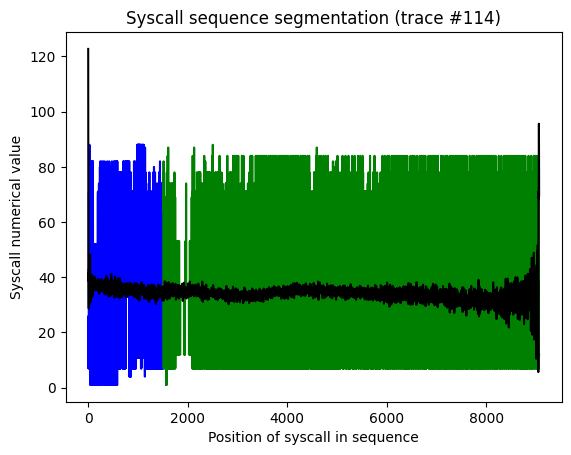

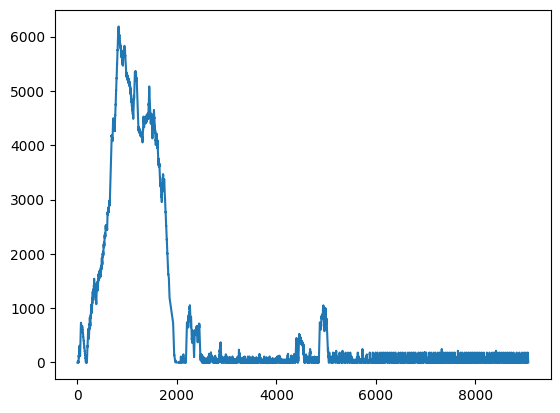

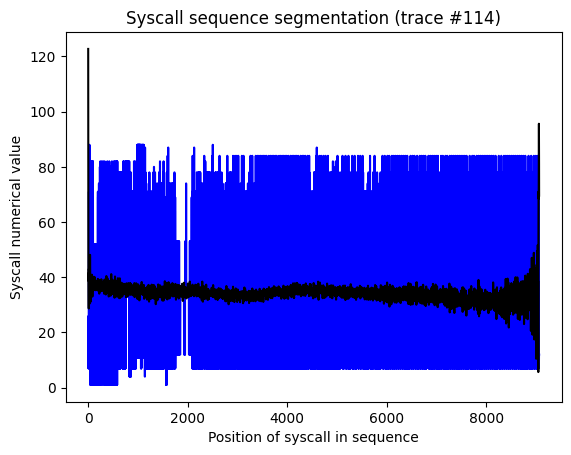

In [300]:
idx = np.random.randint(len(encoded_data))

trace = encoded_data[idx]

trace_idx = [str(int(syscall_idx)) for syscall_idx in trace]


# OFFLINE

suffix_tree = SuffixTree(trace_idx)

lrs = suffix_tree.find_longest_repeating_substring()
lrs = [float(idx) for idx in lrs]

segments = merge_segments(segment_sequence(trace, [lrs]))

plot_segments(segments, idx)


# ONLINE

cusum = cusum_filter(trace, threshold=20)
plt.plot(cusum)

trace_idx_online = []
segments = []
i = 0
while i < len(trace_idx):
    observed_window = trace_idx[i:i+500]
    trace_idx_online.extend(observed_window)
    suffix_tree = SuffixTree(trace_idx_online)
    
    segpair = suffix_tree.get_latest_segment()        
        
    if segpair and len(segpair[0]) < len(observed_window) and len(segpair[1]) < len(observed_window):
        seg1, seg2 = segpair        
        index = i + len(seg1)

        verified = cusum[index] > np.percentile(trace[max(0, index-50):min(index+50, len(trace))], 95)
        
        if not verified:
            if len(segments) == 0:
                segments.append(observed_window)
            else:
                segments[-1].extend(observed_window)
        else:
            if len(segments) == 0: 
                segments.append(seg1)
                segments.append(seg2)
            else:
                segments[-1].extend(seg1)
                segments.append(seg2)
    else:
        if len(segments) == 0:
            segments.append(observed_window)
        else:
            segments[-1].extend(observed_window)
        
    i += 500

segments = list(filter(lambda x : len(x) > 0, segments))

for i, seg in enumerate(segments):
    seg_f = []
    for syscall_idx in seg:
        if syscall_idx != "$":
            seg_f.append(float(syscall_idx))
    if len(seg_f) > 0:
        segments[i] = seg_f
    else:
        segments = segments[:i] + segments[i+1:]

plot_segments(segments, idx)

## Anomaly Detection

We combine all constructed models into a pipeline to detect anomalies in both clean and infected traces, calculating the probabilities of sequences being anomalous.

*Note: the same clean traces have been used for each trial*

In [23]:
initialize_pca()

TRIAL # 1

Processing clean traces...


100%|██████████| 50/50 [03:59<00:00,  4.79s/it]



Processing infected traces...


100%|██████████| 50/50 [03:30<00:00,  4.22s/it]

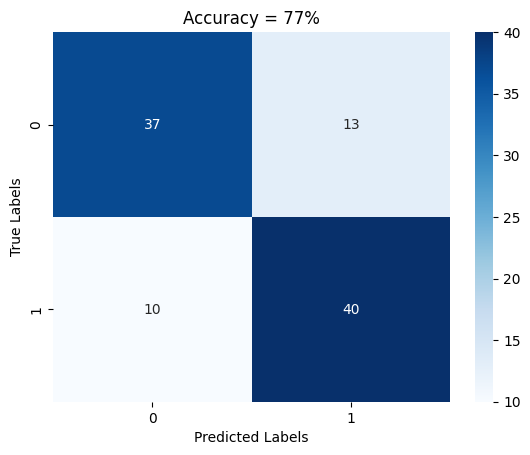

Completed in 7m 30s

TRIAL # 2

Processing clean traces...


 18%|█▊        | 9/50 [00:42<03:14,  4.76s/it]

In [ ]:
SAMPLE_SIZE = int(.25*len(trace_files_clean))

n = CONTEXT_SIZE = 6
 
for trial in range(4):    
    print(f"TRIAL # {trial+1}\n")

    start_timer = time.time()
    
    clean_cnt = 0
    infected_cnt = 0
    trace_files_infected_idx = np.random.randint(len(trace_files_infected) - SAMPLE_SIZE + 1)

    print("Processing clean traces...")
    
    # clean files in test partition
    counter = 0
    for i in tqdm(range(SAMPLE_SIZE)):
        clean_file = trace_files_clean[len(trace_files_clean)-SAMPLE_SIZE+i]
        features, str_args, _ = process_trace(clean_folder, clean_file, syscall_type_mapping)

        syscall_idx = [fv[0] for fv in features]
        trace_idx = [str(int(idx)) for idx in syscall_idx]
        # suffix_tree = SuffixTree(trace_idx)
        # lrs = suffix_tree.find_longest_repeating_substring()
        # lrs = [float(idx) for idx in trace_idx]
        # trace_segments = merge_segments(segment_sequence(syscall_idx, [lrs]))
        # segment_idx = np.cumsum([len(seg) for seg in trace_segments])

        cusum = cusum_filter(syscall_idx, threshold=20)
        
        trace_idx_online = []
        segments = []
        i = 0
        while i < len(trace_idx):
            observed_window = trace_idx[i:i+500]
            trace_idx_online.extend(observed_window)
            suffix_tree = SuffixTree(trace_idx_online)
            
            segpair = suffix_tree.get_latest_segment()        
                
            if segpair and len(segpair[0]) < len(observed_window) and len(segpair[1]) < len(observed_window):
                seg1, seg2 = segpair        
                index = i + len(seg1)
        
                verified = cusum[index] > np.percentile(syscall_idx[max(0, index-50):min(index+50, len(syscall_idx))], 95)
                
                if not verified:
                    if len(segments) == 0:
                        segments.append(observed_window)
                    else:
                        segments[-1].extend(observed_window)
                else:
                    if len(segments) == 0: 
                        segments.append(seg1)
                        segments.append(seg2)
                    else:
                        segments[-1].extend(seg1)
                        segments.append(seg2)
            else:
                if len(segments) == 0:
                    segments.append(observed_window)
                else:
                    segments[-1].extend(observed_window)
                
            i += 500

        segments = list(filter(lambda x : len(x) > 0, segments))

        for j, seg in enumerate(segments):
            # print(j, len(seg), len(segments))
            seg_f = []
            for s_idx in seg:
                if s_idx != "$":
                    seg_f.append(float(s_idx))
            if len(seg_f) > 0:
                if j >= len(segments): print(len(segments), j)
                segments[j] = seg_f
            else:
                segments = segments[:j] + segments[j+1:]

        segment_idx = np.cumsum([len(seg) for seg in segments])
        
        prevIdx = 0
        for idx in segment_idx:
            fv_segment = features[prevIdx:idx]
            sa_segment = str_args[prevIdx:idx]
            prob1, prob2 = sequence_probability(fv_segment, sa_segment, n, syscall_to_cluster, transition_probabilities)
                
            if prob1 < 0.5 or prob2 < 0.5:
                    clean_cnt += 1
                    break
                
            prevIdx = idx
            
    print()
    print("Processing infected traces...")
    
    # infected files
    counter = 0
    for i in tqdm(range(SAMPLE_SIZE)):
        infected_file = trace_files_infected[trace_files_infected_idx+i]
        features, str_args, _ = process_trace(infected_folder, infected_file, syscall_type_mapping)

        syscall_idx = [fv[0] for fv in features]
        trace_idx = [str(int(idx)) for idx in syscall_idx]
        # suffix_tree = SuffixTree(trace_idx)
        # lrs = suffix_tree.find_longest_repeating_substring()
        # lrs = [float(idx) for idx in lrs]
        # trace_segments = merge_segments(segment_sequence(syscall_idx, [lrs]))
        # segment_idx = np.cumsum([len(seg) for seg in trace_segments])

        cusum = cusum_filter(syscall_idx, threshold=20)
        
        trace_idx_online = []
        segments = []
        i = 0
        while i < len(trace_idx):
            observed_window = trace_idx[i:i+500]
            trace_idx_online.extend(observed_window)
            suffix_tree = SuffixTree(trace_idx_online)
            
            segpair = suffix_tree.get_latest_segment()        
                
            if segpair and len(segpair[0]) < len(observed_window) and len(segpair[1]) < len(observed_window):
                seg1, seg2 = segpair        
                index = i + len(seg1)
        
                verified = cusum[index] > np.percentile(syscall_idx[max(0, index-50):min(index+50, len(syscall_idx))], 95)
                
                if not verified:
                    if len(segments) == 0:
                        segments.append(observed_window)
                    else:
                        segments[-1].extend(observed_window)
                else:
                    if len(segments) == 0: 
                        segments.append(seg1)
                        segments.append(seg2)
                    else:
                        segments[-1].extend(seg1)
                        segments.append(seg2)
            else:
                if len(segments) == 0:
                    segments.append(observed_window)
                else:
                    segments[-1].extend(observed_window)
                
            i += 500

        segments = list(filter(lambda x : len(x) > 0, segments))

        for j, seg in enumerate(segments):
            # print(j, len(seg), len(segments))
            seg_f = []
            for s_idx in seg:
                if s_idx != "$":
                    seg_f.append(float(s_idx))
            if len(seg_f) > 0:
                if j >= len(segments): print(len(segments), j)
                segments[j] = seg_f
            else:
                segments = segments[:j] + segments[j+1:]

        segment_idx = np.cumsum([len(seg) for seg in segments])

        prevIdx = 0
        for idx in segment_idx:
            fv_segment = features[prevIdx:idx]
            sa_segment = str_args[prevIdx:idx]
            prob1, prob2 = sequence_probability(fv_segment, sa_segment, n, syscall_to_cluster, transition_probabilities)
            
            if prob1 < 0.5 or prob2 < 0.5:
                    infected_cnt += 1
                    break
                    
            prevIdx = idx

    TP = infected_cnt
    FP = clean_cnt
    
    FN = SAMPLE_SIZE - infected_cnt
    TN = SAMPLE_SIZE - clean_cnt
    
    # label 1: infected
    # label 0: clean
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    
    conf_matrix = [[TN, FP], [FN, TP]]
    ACC = (TP + TN) / (TP + TN + FP + FN)
    
    print('\n')
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Accuracy = {math.floor(ACC*100)}%')
    
    plt.show();

    elapsed = time.time() - start_timer
    
    print(f"Completed in {int(elapsed//60)}m {int(elapsed%60)}s\n")